Ingresamos una única variable pero, predecimos varios instantes de tiempo, la idea ahora es ingresar 24 horas de temp, y predecir 4 horas de temp.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

In [2]:
df = pd.read_csv('weather_dataset_PREprocesado.csv')
df.head()

,datetime,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Split el dataset

In [3]:
def train_val_test_split(serie, tr=0.8, ts=0.1, vl=0.1):
    N = len(serie)
    Ntrain = int(N*tr)
    Nval = int(N*vl)
    Ntest = int(N*ts)

    train = serie[:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    print(f'train: {train.shape}')
    print(f'val: {val.shape}')
    print(f'test: {test.shape}')

    return train, val, test

In [4]:
# recordar que es UNIVARIADO, por lo que será solo T (degC)
train, val, test = train_val_test_split(df['T (degC)'])

train: (336614,)
val: (42076,)
test: (42078,)


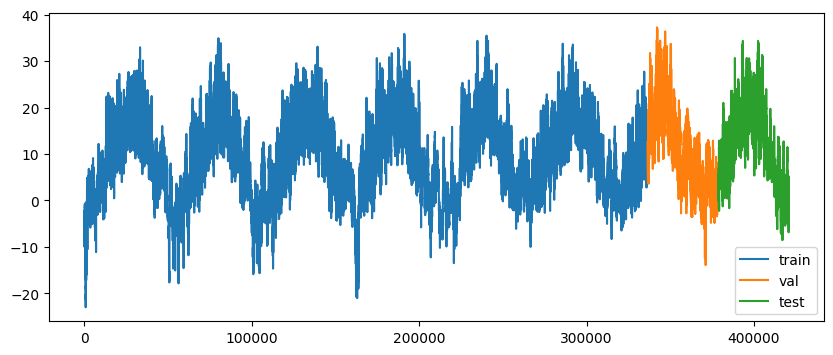

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train, label='train')
ax.plot(val, label='val')
ax.plot(test, label='test')
plt.legend()

In [6]:
def crear_dataset_supervisado(array, input_length, output_length):
    X, Y = [], []

    # Sacamos filas y columnas
    shape = array.shape
    if len(shape) ==1:
        rows, cols = array.shape[0], 1
        array = array.reshape(rows, cols)
    else:
        rows, cols = array.shape

    # Ahora creamos el supervisado, con X y Y
    for i in range(rows - input_length - output_length):
        X.append(array[i:i+input_length, :cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    X = np.array(X)
    Y = np.array(Y)

    return X, Y


In [7]:
# como lo tengo de 10min, 144 seria 24 horas
input_length = 144
# Pongo 24 que serian 4 horas
output_length = 24

x_train, y_train = crear_dataset_supervisado(train.values, input_length,output_length)
x_val, y_val = crear_dataset_supervisado(val.values, input_length, output_length)
x_test, y_test = crear_dataset_supervisado(test.values, input_length, output_length)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}, y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (336446, 144, 1), y_train: (336446, 24, 1)
x_val: (41908, 144, 1), y_val: (41908, 24, 1)
x_test: (41910, 144, 1), y_test: (41910, 24, 1)


## Escalamiento

In [8]:
def escalar_dataset(data_input):

    # Cuando creamos el supervisado dejamos las variables en la posición 2
    NFEATS = data_input['x_train'].shape[2]
    # Se instancia tantos escaladores como columnas, por qué? al parecer es una buena práctica para redes lstm
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # se crear arrays vacios, llenos con 0s
    x_train_s = np.zeros(data_input['x_train'].shape)
    x_val_s = np.zeros(data_input['x_val'].shape)
    x_test_s = np.zeros(data_input['x_test'].shape)
    y_train_s = np.zeros(data_input['y_train'].shape)
    y_val_s = np.zeros(data_input['y_val'].shape)
    y_test_s = np.zeros(data_input['y_test'].shape)

    # Acá escalamos columna por columna, es decir, por separado
    for i in range(NFEATS):
        x_train_s[:, :, i] = scalers[i].fit_transform(data_input['x_train'][:, :, i])
        x_val_s[:, :, i] = scalers[i].transform(data_input['x_val'][:, :, i])
        x_test_s[:, :, i] = scalers[i].transform(data_input['x_test'][:, :, i])

    # lo que entendí es que estos valores son simbólicos nada más, se usa 0 inicialmente para decir que es la única columna, pero bien podriamos usar 1, tambié se usa el ultimo escalador para dar a entender que es el último valor el target, aunque bien podria ser otro valor, no le vi sentido a los números asi que pienso que es simbólico.
    y_train_s[:,:,0] = scalers[-1].fit_transform(data_input['y_train'][:,:,0])
    y_val_s[:,:,0] = scalers[-1].transform(data_input['y_val'][:, :, 0])
    y_test_s[:,:,0] = scalers[-1].transform(data_input['y_test'][:, :, 0])

    data_scaled = {
        'x_train_s': x_train_s,
        'x_val_s': x_val_s,
        'x_test_s': x_test_s,
        'y_train_s': y_train_s,
        'y_val_s': y_val_s,
        'y_test_s': y_test_s
    }

    # Saco el primer escalador para luego hacer la transformacion inversa
    return data_scaled, scalers[0]

In [9]:
# la función de arriba pide un diccionario asi que lo creo
data_in = {
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
    'x_val': x_val,
    'y_val': y_val
}

# entonces escalo y saco los datos
data_s, scaler = escalar_dataset(data_in)
x_train_s, y_train_s = data_s['x_train_s'], data_s['y_train_s']
x_val_s, y_val_s = data_s['x_val_s'], data_s['y_val_s']
x_test_s, y_test_s = data_s['x_test_s'], data_s['y_test_s']

print(x_train.min(), x_train.max())
print(x_train_s.min(), x_train_s.max())

-23.01 35.86
-1.0 0.9999999999999999


## Modelo

In [10]:
# la semilla y una cosa de configuración
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

INPUT_SHAPE = (x_train.shape[1], x_train.shape[2])

model = Sequential()
model.add(LSTM(128, input_shape=INPUT_SHAPE))
# 1 o el output_lenght, que como es univariado es 1
model.add(Dense(6, activation='linear'))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model.compile(optimizer=RMSprop(learning_rate=1e-5), loss=rmse)

hist = model.fit(
    x_train_s, y_train_s,
    epochs=80,
    batch_size=256,
    validation_data=(x_val_s, y_val_s),
    verbose=2
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
1315/1315 - 20s - 15ms/step - loss: 0.2176 - val_loss: 0.1055
Epoch 2/80
1315/1315 - 17s - 13ms/step - loss: 0.0983 - val_loss: 0.0771
Epoch 3/80
1315/1315 - 24s - 18ms/step - loss: 0.0801 - val_loss: 0.0703
Epoch 4/80
1315/1315 - 18s - 14ms/step - loss: 0.0756 - val_loss: 0.0674
Epoch 5/80
1315/1315 - 19s - 15ms/step - loss: 0.0728 - val_loss: 0.0652
Epoch 6/80
1315/1315 - 21s - 16ms/step - loss: 0.0708 - val_loss: 0.0638
Epoch 7/80
1315/1315 - 21s - 16ms/step - loss: 0.0692 - val_loss: 0.0626
Epoch 8/80
1315/1315 - 18s - 14ms/step - loss: 0.0678 - val_loss: 0.0616
Epoch 9/80
1315/1315 - 17s - 13ms/step - loss: 0.0668 - val_loss: 0.0607
Epoch 10/80
1315/1315 - 18s - 14ms/step - loss: 0.0658 - val_loss: 0.0599
Epoch 11/80
1315/1315 - 20s - 15ms/step - loss: 0.0649 - val_loss: 0.0590
Epoch 12/80
1315/1315 - 18s - 13ms/step - loss: 0.0635 - val_loss: 0.0573
Epoch 13/80
1315/1315 - 20s - 15ms/step - loss: 0.0572 - val_loss: 0.0508
Epoch 14/80
1315/1315 - 17s - 13ms/step - loss:

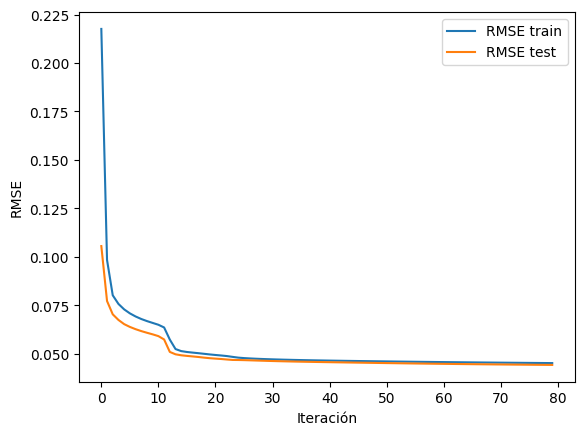

In [11]:
# Graficamos
plt.plot(hist.history['loss'],label='RMSE train')
plt.plot(hist.history['val_loss'], label='RMSE test')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

## Desempeño

In [12]:
rmse_train = model.evaluate(x_train_s,y_train_s, verbose=0)
rmse_test = model.evaluate(x_test_s, y_test_s, verbose=0)
rmse_val = model.evaluate(x_val_s, y_val_s, verbose=0)

print("RMSE Train: ", rmse_train)
print("RMSE Test: ", rmse_test)
print("RMSE Val: ", rmse_val)

RMSE Train:  0.03899731487035751
RMSE Test:  0.0380973145365715
RMSE Val:  0.04026324301958084


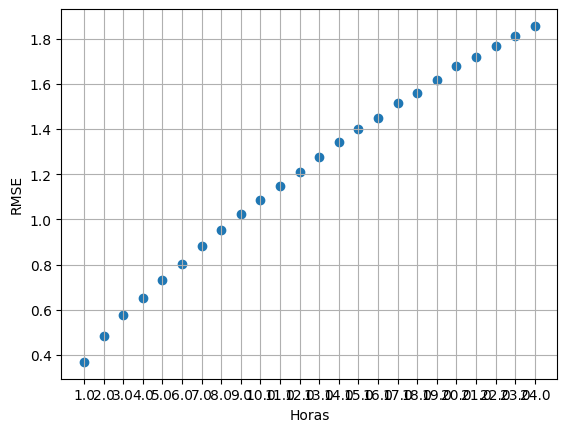

In [13]:
y_test_pred_s = model.predict(x_test_s, verbose=0)
y_test_pred = scaler.inverse_transform(y_test_pred_s)

# Calcular el RMSE para cada instancia de tiempo predicho
diff_cuad = np.square(y_test.squeeze()-y_test_pred)
proms = np.mean(diff_cuad, axis=0)
rmse = np.sqrt(proms)

# Graficar rmse para cada timestep
t = np.linspace(1, 24, 24)

fig,ax=plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Horas')
ax.set_ylabel('RMSE')
plt.xticks(ticks=t, labels=t)
plt.grid()

In [14]:
def predecir(x,model,scaler):
    y_pred_s = model.predict(x, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [15]:
y_test_pred = predecir(x_test_s, model, scaler)

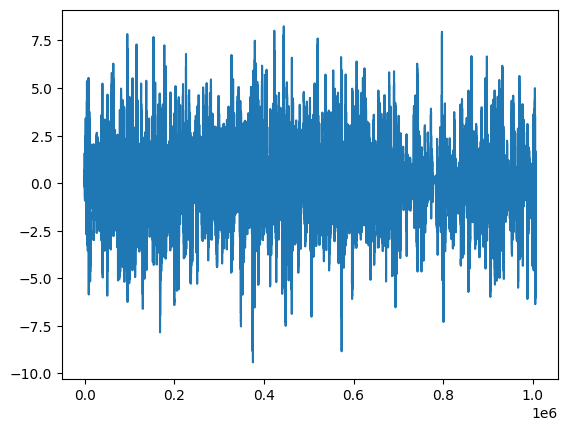

In [16]:
# Nunm de pred
N = len(y_test_pred)
# Esto es para graficar solo un arrelgo de 1 hasta N, de N en N, o sea, de uno en uno.
ndato = np.linspace(1,N,N)

errores = y_test.flatten() - y_test_pred
plt.plot(errores)